In [2]:
'''
Small sample code to reproduce a strange behaviour in overfitting for Cifar100.
'''

from __future__ import print_function

import os

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# Data analysis import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Some definitions : 

# Callbacks, to gather data
class LossHistory(tf.keras.callbacks.Callback):

  def on_train_begin(self, logs={}):
    self.losses = []
    self.accuracies = []

  def on_batch_end(self, batch, logs={}):
    self.losses.append(logs.get('loss'))
    self.accuracies.append(logs.get('accuracy'))

  def on_epoch_end(self, epoch, logs={}):
    import pandas as pd

    df = pd.DataFrame({'accuracies' : self.accuracies,
                       'losses'     : self.losses})

    df.to_csv('saved_models/cifar100_callback_conv.csv', header=True, float_format='%g')

    
# this function monitors training batch per batch
def monitor_on_batch (x, y, x_test, y_test, model, batch_steps_size):

  x_train_r = x.reshape(-1, batch_steps_size, 28, 28, 1)
  y_train_r = y.reshape(-1, batch_steps_size, 10)

  callback = LossHistory()

  loss, test_acc  = model.evaluate(x_test, y_test, verbose=0)
  loss, train_acc = model.evaluate(x, y, verbose=0)

  accuracies = [train_acc, ]
  test_accuracies = [test_acc, ]
  batch_steps    = [0,]
  seen = 0

  for i, (X, y) in enumerate(zip(x_train_r, y_train_r)):

    history = model.fit(X, y,
                        batch_size=batch_size,
                        epochs=1,
                        validation_data=(x_test, y_test),
                        shuffle=False,
                        callbacks=[callback])

    seen += batch_steps_size

    test_accuracies.append(history.history['val_accuracy'][0])
    accuracies.append(callback.accuracies[-1])
    batch_steps.append(seen)

  return {'accuracy'     : accuracies,
          'val_accuracy' : test_accuracies,
          'steps'        : batch_steps }



# This function tries to overfit the model
def overfit(x, y, x_test, y_test, model, epochs):

  callback = LossHistory()

  history = model.fit(x, y,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_test, y_test),
                      shuffle=False,
                      callbacks=[callback],
                      )

  return history, callback

    

In [4]:
# Constant defitions and dataset preprocessing.

batch_size = 32
num_classes = 100
epochs = 100

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'saved_models/keras_cifar100_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()


# Normalization.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Input image dimensions
img_rows, img_cols = 32, 32

# Reshape to channel last
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test  = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
input_shape = (img_rows, img_cols, 3)

# To 1-hot encoded arrays:
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test  = tf.keras.utils.to_categorical(y_test, num_classes)

In [5]:
# Simple model definition.

model = Sequential(name='overfit_cifar100')
model.add(Input(shape=input_shape))
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

opt = tf.keras.optimizers.SGD(learning_rate=0.01)

# Train model using Gradient Descent and Categorical crossentropy loss
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Model: "overfit_cifar100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                460832    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3300      
Total params: 464,580
Trainable params: 464,580
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Training and overfitting, this process takes quite a while, so use data on the repository. 

# hist, callback = overfit(x_train, y_train, x_test, y_test, model, 300) # overfit over 300 batch

# df_history  = pd.DataFrame(hist.history)
# df_callback = pd.DataFrame({'accuracies' : callback.accuracies,
#                            'losses'     : callback.losses})

# df_history.to_csv('saved_models/cifar100_history_conv.csv', header=True, float_format='%g')
# df_callback.to_csv('saved_models/cifar100_callback_conv.csv', header=True, float_format='%g')

# model.save(model_name)

# print('Saved trained model at %s ' % model_name)

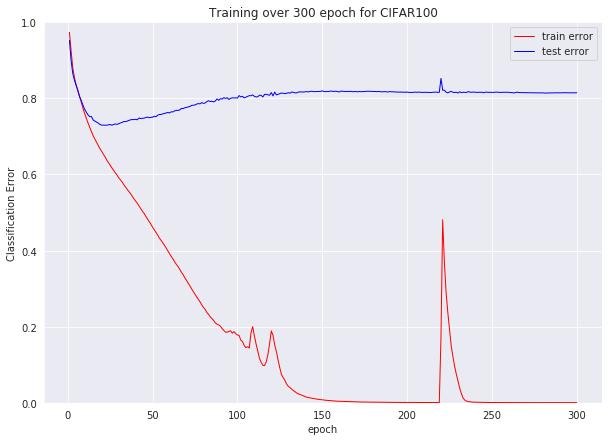

In [8]:
# Plotting

sns.set_style('darkgrid')

dfh = pd.read_csv('saved_models/cifar100_history_conv.csv')

# Plot error as a function of epochs 
dfh['epoch'] = np.arange(300) + 1
dfh['error'] = 1. - dfh['accuracy']
dfh['val_error'] = 1. - dfh['val_accuracy']

dfh.head()


fig, ax = plt.subplots(figsize=(10,7))

dfh.plot(x='epoch', y='error', color='red', linewidth='1', marker='', ax=ax, label='train error')
dfh.plot(x='epoch', y='val_error', color='blue', linewidth='1', marker='', ax=ax, label='test error')
ax.set_title('Training over 300 epoch for CIFAR100')
ax.set_ylabel('Classification Error')
ax.set_ylim(0., 1.)


plt.show()


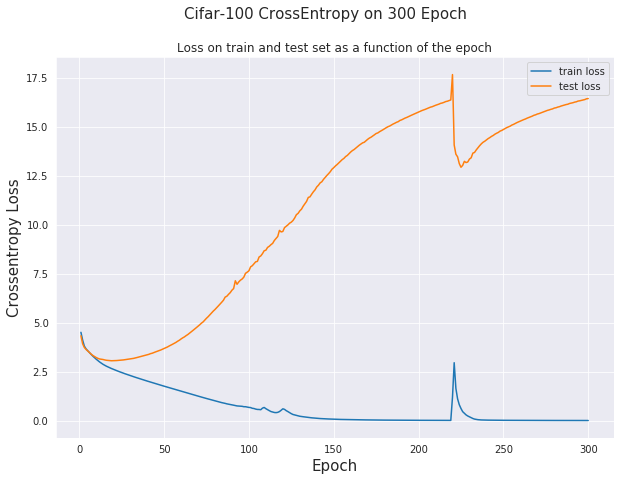

In [31]:
# Plotting of losses

sns.set_style('darkgrid')

dfh = pd.read_csv('saved_models/cifar100_history_conv.csv')

dfh['epoch'] = np.arange(300) + 1

fig, ax = plt.subplots(figsize=(10,7))

ax.plot(dfh['epoch'], dfh['loss'], label='train loss')
ax.plot(dfh['epoch'], dfh['val_loss'], label='test loss')
ax.legend()
ax.set_ylabel('Crossentropy Loss', size=15)
ax.set_xlabel('Epoch', size=15)

fig.suptitle('Cifar-100 CrossEntropy on 300 Epoch', size=15)

ax.set_title('Loss on train and test set as a function of the epoch')

plt.show();